# Drowsiness Detection Using Convolutional Neural Networks


**Group 11**<br>

> - Poorna Addala
> - Rupesh Purum
> - Rohit Vadlala
> - Vamsi Ala

### Motivation


Drawing from 2017 data from police and hospital records, the National Highway Traffic Safety Administration (NHTSA) identified 91,000 car accidents attributed to driver drowsiness, resulting in 50,000 injuries. Additionally, in 2019, 697 fatalities were linked to drowsy driving incidents. In 2022, 693 fatalities were linked to drowsy driving incidents However, the NHTSA acknowledges the difficulty in accurately determining the precise extent of drowsy-driving accidents, injuries, and fatalities, admitting that reported figures are likely underestimates. For instance, a study conducted by the American Automobile Association's foundation for traffic safety estimated over 320,000 drowsy driving accidents annually, with 6400 of them resulting in fatalities. These staggering figures underscore the critical need to address the issue of drowsy driving and its significant impact.

Drowsiness, characterized by feelings of sleepiness in inappropriate situations, poses severe risks despite its transient nature. Typically stemming from fatigue, which impairs attention and alertness, drowsiness can lead to dire consequences, such as delayed reactions to road events. This state often arises from extended periods of driving without sufficient rest or driving during typical sleep hours. Key challenges include the drowsy driver's diminished concentration, resulting in compromised responses to road stimuli.

Fortunately, early detection of driver drowsiness is feasible, allowing for timely warnings to avert potential accidents. Signs of drowsy driving include frequent yawning, prolonged eye closures, and lane drifting. Consequently, intensive research has been dedicated to driver drowsiness detection (DDD) techniques in recent years. Various approaches, including image-based methods utilizing cameras to analyze driver behavior and facial expressions, have been proposed to identify drowsiness indicators promptly and prevent accidents<br><br>
**References -**<br>
1. National Highway Traffic Safety Administration Drowsy Driving. [(accessed on 2 May 2024)]<br> https://www.nhtsa.gov/risky-driving/drowsy-driving
2. National Institutes of Health Drowsiness. [(accessed on 2 May 2024)]<br>
https://medlineplus.gov/ency/article/003208.htm#:~:text=Drowsiness%20refers%20to%20feeling%20abnormally,situations%20or%20at%20inappropriate%20times
3. National Safety Council Drivers are Falling Asleep Behind the Wheel.<br>
https://www.nsc.org/road-safety/safety-topics/fatigued-driving
4. National Sleep Foundation Drowsy Driving. [(accessed on 2 May 2024)].<br>
https://www.sleepfoundation.org/articles/drowsy-driving

**Objective**<br>
The objective of this project is to address the risk to public health that drowsiness poses to drivers, as drowsiness plays a major role in motor vehicle crashes. A convolutional neural network (CNN) model will be created to identify drowsiness in drivers based on facial signals using the Driver Drowsiness Dataset (DDD). Hyperparameters will be adjusted to optimize the model's accuracy and reliability, and they will be validated in real-world scenarios. The project's goal is to reduce the number of car accidents caused by drowsiness in order to improve road safety.

###  Importing Necessary libraries

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

from keras.models import Model,Sequential
from keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Flatten,Dense,GlobalAveragePooling2D,BatchNormalization
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import layers as layers
from keras.optimizers import Adam, SGD
from collections import Counter
from keras.preprocessing import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator as data_augment

tf.random.set_seed(1)

### Preprocessing the Data 

**Block1**<br>
**Data Augmentation:**<br>
Defining two data generators for training (data_generate_training) and testing (data_generate_test) purposes.
Augmentation parameters include rescaling pixel values, applying shear and zoom transformations, enabling horizontal flipping, and allowing for horizontal and vertical shifts. Additionally, a method for filling newly created pixels is specified.
The training data generator (data_generate_training) includes a `validation split of 15%`.

Images are resized to a target size of `227x227` pixels and grouped into batches of `32` images.
Two generators are created: traind for training data and testd for validation data.
A seed value of 123 is set for reproducibility

**Block2**<br>
**Data Augmentation:**<br>
Using the flow_from_directory method to generate batches of images from the images directory.<br>
Images are resized to a target size of 32x32 pixels and grouped into batches of `32` images.<br>
Two generators are created: training_generator for training data and validation_generator for validation data.<br>
The `class_mode` parameter is set to `categorical` to indicate multi-class classification.<br>
`Training data` is shuffled (`shuffle=True`), while `validation data` is not shuffled (`shuffle=False`).<br>
The color mode is specified as `rgb`.

**Need to check the below two cells. Why are we using ImageGenerator twice**. I am adding two markup as `Blcok1` and `Block2` for identifying.

#### Block1

In [4]:
#data augmetation 
data_generate_training = data_augment (rescale=1./255, 
                              shear_range = 0.2,
                              zoom_range = 0.2,
                              fill_mode = "nearest",
                              horizontal_flip = True,
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,
                              validation_split = 0.20)

data_generate_test = data_augment(rescale = 1./255)

#data preprocessing and augmentation
training_generator = data_generate_training.flow_from_directory("/Users/poorna/Downloads/DDD",
                                          target_size = (227, 227),
                                          seed = 123,
                                          batch_size = 32,
                                          subset = "training")

validation_generator = data_generate_training.flow_from_directory("/Users/poorna/Downloads/DDD",
                                          target_size = (227, 227),
                                          seed = 123,
                                          batch_size = 32,
                                          subset = "validation")

Found 33435 images belonging to 2 classes.
Found 8358 images belonging to 2 classes.


#### Visualizing the images of the training data

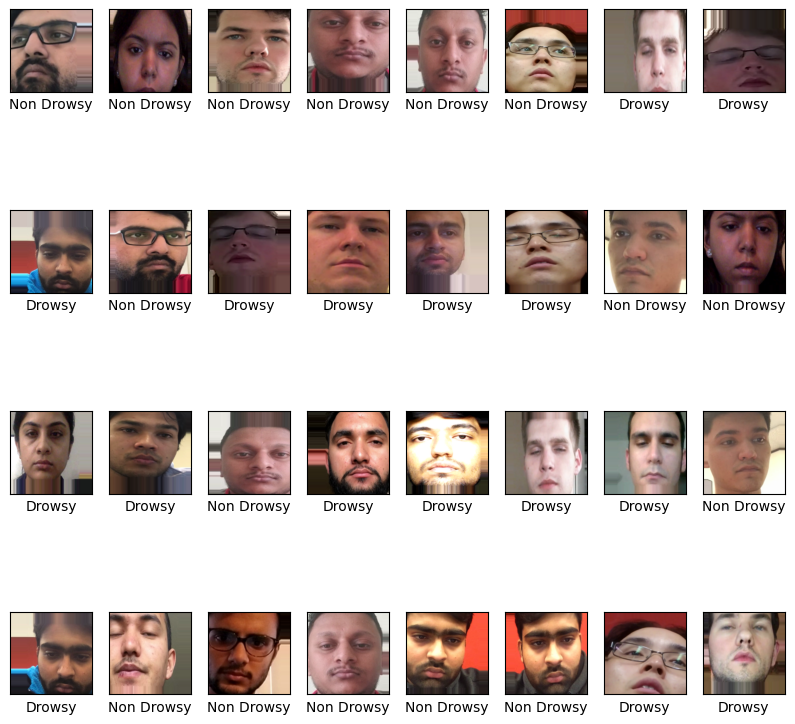

In [5]:
# get all the classes of images found in the training data
facial_image_indices = training_generator.class_indices

# get all the class lables of images found in the training data
training_labels = list(training_generator.class_indices.keys())

# get the first batch of images and associated labels
images, labels = training_generator[0]

# get the size of the batch
batch_size = len(images)

# do some calculations to accomodate the number of images (which is determined by the batch size)
cols = 8
rows = batch_size//cols

# display the images
plt.figure(figsize=(10,10))
for i in range(batch_size):
    plt.subplot(rows,cols,i+1)
# if you prefer to see images without the grid and axes labels, uncomment the following 3 lines    
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(training_labels[int(np.argmax(labels[i]))])
plt.show()

### Building CNN Model

#### Model Architecture

**Convolutional Layers (Conv2D):**<br>
These layers apply convolutional filters to the input images. The first parameter (32, 64, 128) determines the number of filters, which capture different features in the input images. The second parameter ((3, 3)) specifies the size of the filters.<br>
**Batch Normalization:** This layer normalizes the activations of the previous convolutional layer, improving the stability and performance of the model.<br>
**MaxPooling2D:** Downsample the output of the convolutional layers, reducing the spatial dimensions of the feature maps and extracting the most important features.<br>
**Dropout:** Randomly deactivate a fraction (here, 0.5 or 50%) of neurons during training, preventing overfitting by promoting the learning of more robust features.<br>


#### Model Configuration

**Input Shape:** The input images are expected to have a shape of (227, 227, 3), where 227x227 represents the dimensions of the image and 3 represents the number of color channels (RGB).<br>
**Activation Functions:** ReLU (Rectified Linear Unit) is used as the activation function in convolutional layers to introduce non-linearity, helping the model learn complex patterns. Sigmoid activation is used in the output layer for binary classification tasks.<br>
**Kernel Regularization:** L1 regularization is applied to the second Dense layer (128 neurons) to prevent overfitting by penalizing large weights in the model.

In [6]:
# Define the CNN model
CNNmodel = keras.Sequential([
    # Convolutional layer 1
    layers.Conv2D(64, (3, 3), input_shape=(227, 227, 3), activation='relu'),  # 64 filters, each 3x3
    layers.BatchNormalization(),  # Batch normalization
    layers.MaxPooling2D((2, 2)),  # Max pooling with 2x2 pool size
    layers.Dropout(0.5),  # Dropout for regularization
    
    # Convolutional layer 2
    layers.Conv2D(128, (3, 3), activation='relu'),  # 128 filters, each 3x3
    layers.BatchNormalization(),  # Batch normalization
    layers.MaxPooling2D((2, 2)),  # Max pooling with 2x2 pool size
    layers.Dropout(0.5),  # Dropout for regularization
    
    # Convolutional layer 3
    layers.Conv2D(256, (3, 3), activation='relu'),  # 256 filters, each 3x3
    layers.BatchNormalization(),  # Batch normalization
    layers.MaxPooling2D((2, 2)),  # Max pooling with 2x2 pool size
    layers.Dropout(0.5),  # Dropout for regularization
    
    # Flatten layer to convert 2D feature maps to 1D feature vectors
    layers.Flatten(),
    
    # Fully connected layer 1
    layers.Dense(512, activation='relu'),  # 512 neurons
    layers.Dropout(0.5),  # Dropout for regularization
    
    # Fully connected layer 2
    layers.Dense(256, activation='relu'),  # 256 neurons
    layers.Dropout(0.5),  # Dropout for regularization
    
    # Fully connected layer 3
    layers.Dense(128, activation='relu'),  # 128 neurons
    layers.Dropout(0.5),  # Dropout for regularization
    
    # Output layer with sigmoid activation for binary classification
    layers.Dense(2, activation='sigmoid')  # 2 output neurons for binary classification
])

/Users/poorna/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


#### Model Compilation

**Optimizer:** `adam` optimizer is chosen for training the model. Adam combines the advantages of AdaGrad and RMSProp optimizers, providing adaptive learning rates and efficient optimization.<br>
**Loss Function:** `binary_crossentropy` is selected as the loss function, suitable for binary classification tasks.<br>
**Metrics:** `Accuracy` is used as the evaluation metric to assess the performance of the model during training and validation.<br>

In [7]:
CNNmodel.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

#### Model Training

The model is trained using the traind data generator for `1` epoch (one pass through the entire dataset) while validating on the testd data generator. This setup allows for efficient handling of large datasets and incorporates data augmentation during training.

In [8]:
history = CNNmodel.fit(training_generator, epochs = 5, validation_data = validation_generator)

Epoch 1/5


/Users/poorna/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1045/1045 ━━━━━━━━━━━━━━━━━━━━ 11597s 11s/step - accuracy: 0.5687 - loss: 8.2426 - val_accuracy: 0.5347 - val_loss: 3.9354
Epoch 2/5
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 9370s 9s/step - accuracy: 0.7543 - loss: 0.5159 - val_accuracy: 0.5098 - val_loss: 3.2809
Epoch 3/5
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 6647s 6s/step - accuracy: 0.8750 - loss: 0.3280 - val_accuracy: 0.5999 - val_loss: 2.4423
Epoch 4/5
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3362s 3s/step - accuracy: 0.9333 - loss: 0.1978 - val_accuracy: 0.5285 - val_loss: 4.6845
Epoch 5/5
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 3147s 3s/step - accuracy: 0.9442 - loss: 0.1690 - val_accuracy: 0.5790 - val_loss: 2.1610


Summary of the architecture and parameters of the CNN model

In [9]:
CNNmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 225, 225, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 225, 225, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 110, 110, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 55, 55, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 53, 53, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 53, 53, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    88,605,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,425,032 (1020.15 MB)

 Trainable params: 89,141,378 (340.05 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 178,282,758 (680.09 MB)

In [10]:
CNNmodel.save("/Users/poorna/Downloads/DDD/CNN_DDD_model.h5")

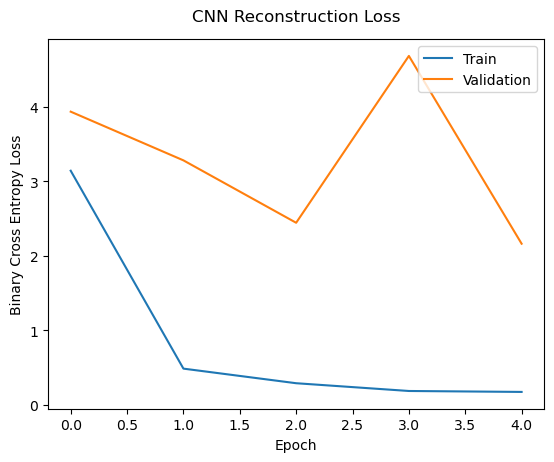

In [11]:
# Plot training and validation loss scores
# against the number of epochs.
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Binary Cross Entropy Loss')
plt.xlabel('Epoch')
plt.title('CNN Reconstruction Loss', pad=13)
plt.legend(loc='upper right')

Predictions are made on the validation dataset (validation_generator) using the trained CNN model (CNNmodel). <br>The `predict` method returns the predicted probabilities for each class. The `argmax` function is then used to find the class with the highest probability for each prediction, effectively converting the probabilities into class labels.

#### Analysis

**Confusion Matrix:** The confusion matrix is a table that summarizes the performance of a classification algorithm. It presents the counts of true positive, true negative, false positive, and false negative predictions made by the model.<br>
**Classification Report:** The classification report provides a comprehensive summary of the model's performance, including metrics such as precision, recall, F1-score, and support for each class. It also includes the overall accuracy of the model.
These metrics provide valuable insights into the model's performance, highlighting its strengths and weaknesses in classifying different categories. They are crucial for evaluating and fine-tuning the model to improve its performance on unseen data.









In [12]:
# Get true labels from the DirectoryIterator object
y_true = (validation_generator.classes)

# Predict labels using the trained model
y_pred = np.argmax(CNNmodel.predict(validation_generator), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

# Generate classification report
report = classification_report(y_true, y_pred)

print("Classification Report:")
print(report)

262/262 ━━━━━━━━━━━━━━━━━━━━ 129s 492ms/step
Confusion Matrix:
[[3887  582]
 [3378  511]]
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.87      0.66      4469
           1       0.47      0.13      0.21      3889

    accuracy                           0.53      8358
   macro avg       0.50      0.50      0.43      8358
weighted avg       0.50      0.53      0.45      8358



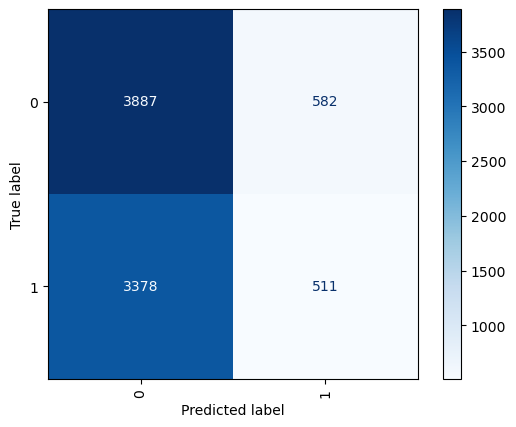

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation='vertical')
plt.show()


True Positive (TP): **true_positive** <br>
False Positive (FP): **false_positive** <br>
True Negative (TN): **true_negative** <br>
False Negative (FN): **false_negative** <br>

### Model Performance Overview

**Precision**: Class 0 (Non- Drowsy) is 0.54, meaning when the model predicts an instance as class 0, it is correct 54% of the time. Class 1 (Drowsy) is 0.47, meaning when the model predicts an instance as class 1, it is correct 47% of the time. Precision measures the accuracy of positive predictions.
**Recall**: Class 0: 0.87, indicating that the model identifies 87% of all actual class 0 instances correctly. Class 1: 0.13, indicating that the model identifies only 13% of all actual class 1 instances correctly. Recall measures the ability of the model to correctly identify positive instances
**F1-Score**: Class 0: 0.66, showing a relatively better balance between precision and recall for class 0. Class 1: 0.21, showing that the model is quite poor at predicting class 1, with a significant imbalance between precision and recall. The F1-score is the harmonic mean of precision and recall, providing a balance between the two metrics
**Overall Accuracy** is 53%, suggesting that the model correctly predicts both classes about 53% of the time across all predictions.


#### Implications

**True Positive (TP):** Correctly identified as Drowsy<br>
**False Positive (FP):** Incorrectly classified as Drowsy when actually Non-Drowsy. This could lead to a `false alarms` <br>
**True Negative (TN):** Correctly identified as Non-Drowsy.<br>
**False Negative (FN):** Incorrectly classified as Non-Drowsy when actually Drowsy. This is a `critical error` as it means a drowsy driver is not being detected, posing a `safety risk`.<br>

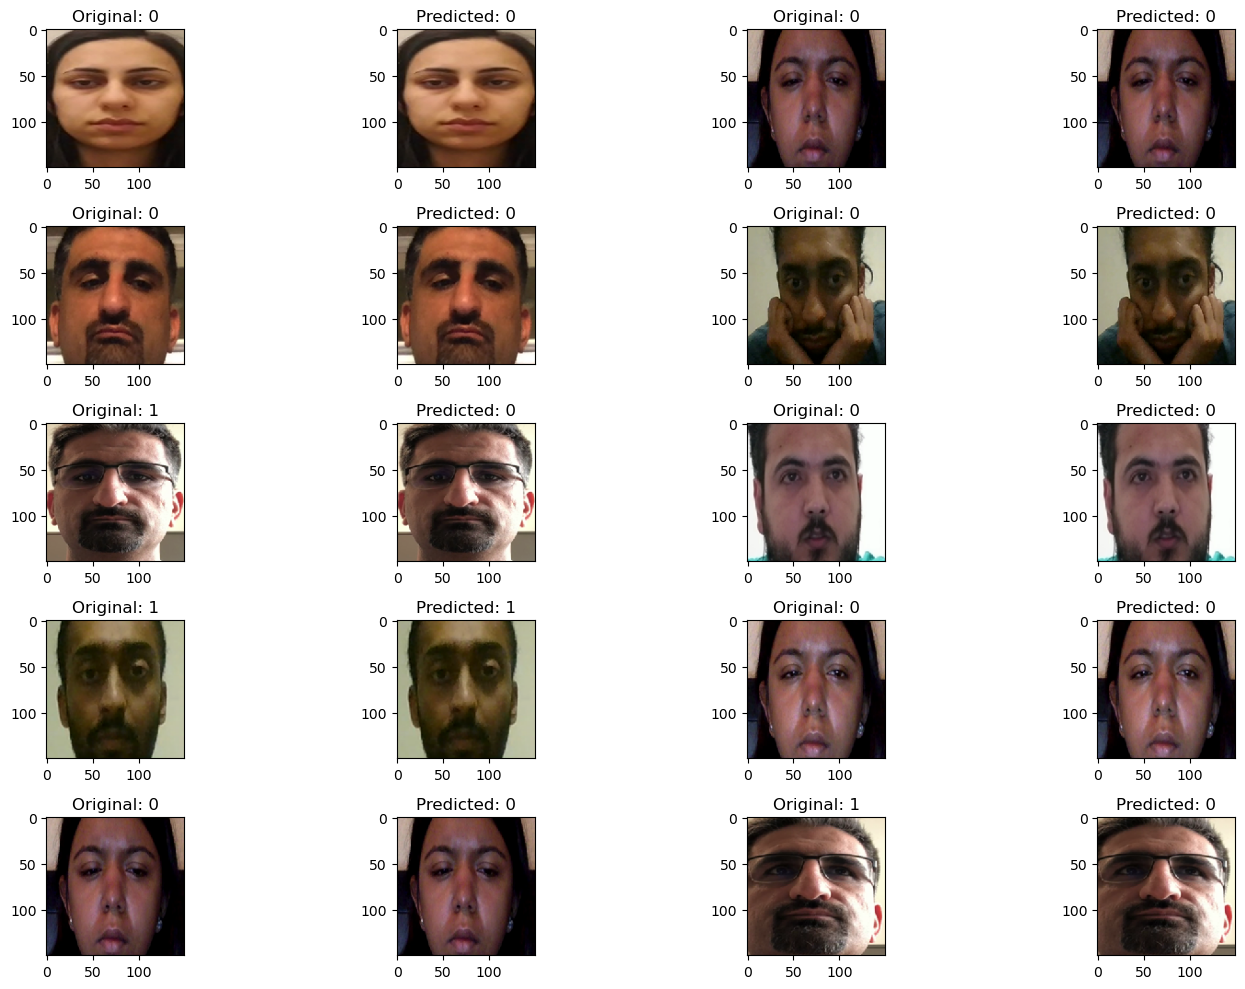

In [18]:
# Select 10 random indices for images
indices = np.random.choice(len(y_true), 10, replace=False)

# Display original and predicted images side by side
plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    plt.subplot(5, 4, 2*i + 1)
    img_path = validation_generator.filepaths[idx]
    img = image.load_img(img_path, target_size=(150, 150))  # Adjust target_size as per your model's input shape
    plt.imshow(img)
    plt.title(f"Original: {y_true[idx]}")

    plt.subplot(5, 4, 2*i + 2)
    img = image.load_img(img_path, target_size=(150, 150))  # Adjust target_size as per your model's input shape
    plt.imshow(img)
    plt.title(f"Predicted: {y_pred[idx]}")
plt.tight_layout()
plt.show()


# Discussion

### Discussion

1. **Performance Discrepancy Between Classes**:
   - There's a clear discrepancy in the model's ability to predict class 0 over class 1. The model performs relatively well in identifying class 0 instances but struggles significantly with class 1 instances, as indicated by the very low recall for class 1.

2. **Potential Bias Toward Majority Class**:
   - The model's better performance on class 0 suggests it might be biased towards the majority class, assuming class 0 has higher representation in the dataset. This bias leads to high recall for class 0 and low recall for class 1.

3. **Impact of Training Duration**:
   - Since the model was only trained for 5 epochs, it is possible that it has not sufficiently learned to generalize well, particularly for the underrepresented or more complex class 1. Increasing the number of epochs might help the model to better learn the characteristics of class 1.

4. **Improvement Strategies**:
   - **Increase Training Epochs**: Training the model for more epochs might help in achieving better generalization, especially for the poorly performing class 1.
   - **Class Balancing Techniques**: Employ techniques like SMOTE, class weights, or undersampling the majority class to handle the class imbalance issue.
   - **Model Adjustments**: Experiment with different model architectures or learning rates to see if adjustments could yield better balanced results.
   - **Feature Engineering**: Investigate if adding, removing, or transforming features could improve model performance, especially for class 1.
   - **Evaluation Metric Consideration**: Given the imbalance, metrics like the area under the ROC curve (AUC-ROC) might provide a better indication of model performance across classes than accuracy.


The current model, trained for a relatively short period (5 epochs), shows a significant bias towards accurately predicting class 0 while underperforming drastically on class 1. To improve its performance, especially for class 1, consider extending training duration, applying class balancing techniques, and potentially adjusting model parameters and features. Further exploration and experimentation will be essential to achieve a more balanced and effective model.

### Impact of Increased Training Epochs

Extending the number of training epochs could substantially enhance the model's performance. Typically, a longer training duration allows the model more opportunities to learn from the training data, adjusting its weights and biases to better capture the underlying patterns and complexities, particularly in classes that are underrepresented or more challenging to predict. Increasing epochs may lead to improved precision and recall for class 1, as the model could potentially develop a better understanding of the features that distinguish this class. However, care must be taken to monitor for overfitting, where the model becomes too specialized to the training data, losing its generalization ability on unseen data. Employing strategies such as cross-validation, early stopping, or adjusting learning rates can help mitigate this risk while still capitalizing on the benefits of longer training periods. By carefully managing these factors, an increase in epochs could lead to a more robust and balanced performance across both classes, thus addressing the current deficiencies noted in the classification report.